# Predicting the Probability of Mugging & Pedestrian Car Collision

I am interested in finding the best model. But first, I will use default settings. Then, I will use grid search to narrow down the paramerters I should use. Finally, I will compare this best model to the one produced by the default settings. I am going to try logistic regression and random forest.

In [2]:
from sklearn.model_selection import train_test_split # to measure within momdel acuracy
from sklearn.preprocessing import StandardScaler # need to scale data for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble  import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import osmnx
import pickle
import folium
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import numpy
import time
import geopandas
from scipy import ndimage, interpolate
from photutils.utils import ShepardIDWInterpolator 

In [3]:
# loading data
robbery_model_data_dummies_bal = pandas.read_pickle('C:/Users/jodyn/Google Drive/Insight Data Science/Insight/Processed Data/robbery_model_data_dummies_bal.pkl')
pedestrian_model_data_dummies_bal = pandas.read_pickle('C:/Users/jodyn/Google Drive/Insight Data Science/Insight/Processed Data/pedestrian_model_data_dummies_bal.pkl')

In [4]:
# Labels are the values we want to predict
robbery_labels = robbery_model_data_dummies_bal['Presence_A']
robbery_features = robbery_model_data_dummies_bal.drop(['Presence_A','Latitude', 'Longitude',
                                                                'geometry'], axis = 1)
robbery_model_names = list(robbery_model_data_dummies_bal.drop(['Presence_A','Latitude', 'Longitude',
                                                                'geometry'], axis = 1)) 
pedestrian_labels = pedestrian_model_data_dummies_bal['Presence_A']
pedestrian_features = pedestrian_model_data_dummies_bal.drop(['Presence_A','Longitude', 'Latitude',
                                                              'geometry'], axis = 1)
pedestrian_features_names = list(pedestrian_model_data_dummies_bal.drop(['Presence_A','Longitude', 'Latitude',
                                                              'geometry'], axis = 1))
# Split the data into training and testing sets
robbery_train, robbery_test, robbery_presence_train, robbery_presence_test = train_test_split(
    robbery_features,robbery_labels, test_size=0.3, random_state=42)
pedestrian_train, pedestrian_test, pedestrian_presence_train, pedestrian_presence_test = train_test_split(
    pedestrian_features,pedestrian_labels, test_size=0.3, random_state=42)

In [5]:
# Scale data for logistic regression
scaler = StandardScaler()
robbery_train_lr = pandas.DataFrame(scaler.fit_transform(robbery_train),
                                   columns=robbery_model_names)

robbery_test_lr = pandas.DataFrame(scaler.fit_transform(robbery_test),
                                  columns=robbery_model_names)

scaler = StandardScaler()
pedestrian_train_lr = pandas.DataFrame(scaler.fit_transform(pedestrian_train),
                                   columns=pedestrian_features_names)

pedestrian_test_lr = pandas.DataFrame(scaler.fit_transform(pedestrian_test),
                                  columns=pedestrian_features_names)

In [6]:
# Time to build the base model
robbery_model_LR = LogisticRegression(max_iter=500)
robbery_model_LR.fit(robbery_train_lr, robbery_presence_train)
robbery_model_prediction_LR = robbery_model_LR.predict(robbery_test_lr)

pedestrian_model_LR = LogisticRegression(max_iter=500)
pedestrian_model_LR.fit(pedestrian_train_lr, pedestrian_presence_train)
pedestrian_model_prediction_LR = pedestrian_model_LR.predict(pedestrian_test_lr)

In [7]:
# how did these models perform?
print(classification_report(robbery_presence_test, robbery_model_prediction_LR))

              precision    recall  f1-score   support

         0.0       0.67      0.69      0.68      1512
         1.0       0.69      0.67      0.68      1573

    accuracy                           0.68      3085
   macro avg       0.68      0.68      0.68      3085
weighted avg       0.68      0.68      0.68      3085



In [8]:
print(classification_report(pedestrian_presence_test, pedestrian_model_prediction_LR))

              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88      1960
         1.0       0.85      0.91      0.88      1900

    accuracy                           0.88      3860
   macro avg       0.88      0.88      0.88      3860
weighted avg       0.88      0.88      0.88      3860



## Random Forest

In [9]:
# Time to build the base model
robbery_model_RF = RandomForestClassifier()
robbery_model_RF.fit(robbery_train, robbery_presence_train)
robbery_model_prediction_RF = robbery_model_RF.predict(robbery_test)
print(classification_report(robbery_presence_test,robbery_model_prediction_RF))

              precision    recall  f1-score   support

         0.0       0.76      0.82      0.79      1512
         1.0       0.81      0.75      0.78      1573

    accuracy                           0.78      3085
   macro avg       0.78      0.78      0.78      3085
weighted avg       0.79      0.78      0.78      3085



In [10]:
# Time to build the base model
pedestrian_model_RF = RandomForestClassifier()
pedestrian_model_RF.fit(pedestrian_train, pedestrian_presence_train)
pedestrian_model_prediction_RF = pedestrian_model_RF.predict(pedestrian_test)
print(classification_report(pedestrian_presence_test,pedestrian_model_prediction_RF))

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96      1960
         1.0       0.94      0.97      0.96      1900

    accuracy                           0.96      3860
   macro avg       0.96      0.96      0.96      3860
weighted avg       0.96      0.96      0.96      3860



# Model Tuning

## Logistic Regression

In [11]:
# Create first pipeline for base without reducing features.
pipe_lr = Pipeline([('classifier' , LogisticRegression())])

# Create param grid.

param_grid_lr = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : numpy.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']}]

In [12]:
# Create grid search object
grid_search_lr = GridSearchCV(pipe_lr, param_grid = param_grid_lr, cv = 5, verbose=True, n_jobs=-1)

start_time = time.time()

# Fit on data
robbery_best_lr = grid_search_lr.fit(robbery_train_lr, robbery_presence_train)
print("Best: %f using %s" % (robbery_best_lr.best_score_, robbery_best_lr.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.8min finished


Best: 0.694314 using {'classifier': LogisticRegression(C=0.03359818286283781, penalty='l1', solver='liblinear'), 'classifier__C': 0.03359818286283781, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Execution time: 107.17637777328491 ms


In [13]:
start_time = time.time()
pedestrian_best_lr = grid_search_lr.fit(pedestrian_train_lr, pedestrian_presence_train)
print("Best: %f using %s" % (pedestrian_best_lr.best_score_, pedestrian_best_lr.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   48.0s finished


Best: 0.870865 using {'classifier': LogisticRegression(C=0.03359818286283781, penalty='l1', solver='liblinear'), 'classifier__C': 0.03359818286283781, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Execution time: 48.55641484260559 ms


In [14]:
# does this model perform better?
pedestrian_model_best_LR = LogisticRegression(penalty='l1', C = 0.03359818286283781, solver='liblinear', 
                                              max_iter=500)
pedestrian_model_best_LR.fit(pedestrian_train_lr, pedestrian_presence_train)
pedestrian_model_prediction_best_LR = pedestrian_model_best_LR.predict(pedestrian_test_lr)
# how did these models perform?
print(classification_report(pedestrian_presence_test, pedestrian_model_prediction_best_LR))

              precision    recall  f1-score   support

         0.0       0.91      0.84      0.87      1960
         1.0       0.85      0.91      0.88      1900

    accuracy                           0.88      3860
   macro avg       0.88      0.88      0.88      3860
weighted avg       0.88      0.88      0.88      3860



In [15]:
# does this model perform better?
robbery_model_best_LR = LogisticRegression(penalty='l1', C = 0.03359818286283781, solver='liblinear', 
                                              max_iter=500)
robbery_model_best_LR.fit(robbery_train_lr, robbery_presence_train)
robbery_model_prediction_best_LR = robbery_model_best_LR.predict(robbery_test_lr)
# how did these models perform?
print(classification_report(robbery_presence_test, robbery_model_prediction_best_LR))

              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      1512
         1.0       0.70      0.69      0.70      1573

    accuracy                           0.69      3085
   macro avg       0.69      0.69      0.69      3085
weighted avg       0.69      0.69      0.69      3085



## Random Forest

In [19]:
# Create first pipeline for base without reducing features.
pipe_rf = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid_rf = [
     {
    'classifier__bootstrap': [True],
    'classifier__max_depth': [80, 90, 100, 110],
    'classifier__max_features': [2, 3, 4],
    'classifier__min_samples_leaf': [3, 4, 5],
    'classifier__min_samples_split': [8, 10, 12],
    'classifier__n_estimators': [100, 200, 300, 1000]
}
]

grid_search_rf = GridSearchCV(pipe_rf, param_grid = param_grid_rf, cv = 3, n_jobs = -1, verbose = 2)

In [20]:
# Fit on data
start_time = time.time()
robbery_best_rf = grid_search_rf.fit(robbery_train, robbery_presence_train)
print("Best: %f using %s" % (robbery_best_rf.best_score_, robbery_best_rf.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 14.2min finished


Best: 0.767681 using {'classifier__bootstrap': True, 'classifier__max_depth': 90, 'classifier__max_features': 4, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 1000}
Execution time: 864.5156416893005 ms


In [21]:
start_time = time.time()
pedestrian_best_rf = grid_search_rf.fit(pedestrian_train, pedestrian_presence_train)
print("Best: %f using %s" % (pedestrian_best_rf.best_score_, pedestrian_best_rf.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 15.2min finished


Best: 0.892960 using {'classifier__bootstrap': True, 'classifier__max_depth': 100, 'classifier__max_features': 4, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 300}
Execution time: 917.182361125946 ms


In [22]:
# does this model perform better?
pedestrian_model_best_RF = RandomForestClassifier(bootstrap= True, max_depth = 100, 
                                                  max_features= 4, min_samples_leaf = 3,
                                                  min_samples_split = 8, n_estimators = 300)
pedestrian_model_best_RF.fit(pedestrian_train, pedestrian_presence_train)
pedestrian_model_prediction_best_RF = pedestrian_model_best_RF.predict(pedestrian_test)
# how did these models perform?
print(classification_report(pedestrian_presence_test, pedestrian_model_prediction_best_RF))

              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      1960
         1.0       0.92      0.89      0.90      1900

    accuracy                           0.91      3860
   macro avg       0.91      0.91      0.91      3860
weighted avg       0.91      0.91      0.91      3860



In [23]:
# does this model perform better?
robbery_model_best_RF = RandomForestClassifier(bootstrap= True, max_depth = 90, 
                                                  max_features= 4, min_samples_leaf = 3,
                                                  min_samples_split = 8, n_estimators = 1000)
robbery_model_best_RF.fit(robbery_train, robbery_presence_train)
robbery_model_prediction_best_RF = robbery_model_best_RF.predict(robbery_test)
# how did these models perform?
print(classification_report(robbery_presence_test, robbery_model_prediction_best_RF))

              precision    recall  f1-score   support

         0.0       0.73      0.82      0.77      1512
         1.0       0.81      0.71      0.75      1573

    accuracy                           0.76      3085
   macro avg       0.77      0.76      0.76      3085
weighted avg       0.77      0.76      0.76      3085



Now that I have a pretty good model, my next step is to make AUC plots and assess the how features compared in their relative importance.

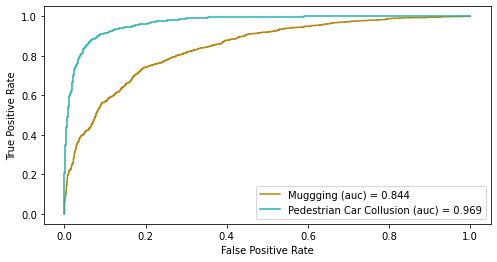

In [24]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
#import scikitplot as skplt
import matplotlib.pyplot as plt

robbery_pred_proba = robbery_model_best_RF.predict_proba(robbery_test)[::,1]
fpr_r, tpr_r, _ = metrics.roc_curve(robbery_presence_test,  robbery_pred_proba)
auc_r = metrics.roc_auc_score(robbery_presence_test, robbery_pred_proba)

pedestrian_pred_proba = pedestrian_model_best_RF.predict_proba(pedestrian_test)[::,1]
fpr_p, tpr_p, _ = metrics.roc_curve(pedestrian_presence_test,  pedestrian_pred_proba)
auc_p = metrics.roc_auc_score(pedestrian_presence_test, pedestrian_pred_proba)

figure, ax = plt.subplots(1, figsize=(8, 4))
ax.plot(fpr_r,tpr_r,label="Muggging (auc) = "+str(round(auc_r,3)), color = "darkgoldenrod")
ax.plot(fpr_p,tpr_p,label="Pedestrian Car Collusion (auc) = "+str(round(auc_p,3)), color = "lightseagreen")
ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_ylabel('True Positive Rate', fontsize=10)
plt.legend(loc=4)
save_results_to = 'C:/Users/jodyn/PycharmProjects/InsightFDS/notebooks/figures/'
plt.savefig(save_results_to + 'AUC.png', dpi = 300)

In [25]:
numpy.set_printoptions(suppress=True) #prevent numpy exponential
importance_pedestrian = numpy.array(pedestrian_model_best_RF.feature_importances_)
importance_robbery = numpy.array(robbery_model_best_RF.feature_importances_)

In [26]:
importance_pedestrian = importance_pedestrian.astype(float)
importance_robbery = importance_robbery.astype(float)

In [27]:
pedestrian_x_names = list(map(lambda st: str.replace(st, "Hood_ID_", "Hood ID "), pedestrian_features_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "YEAR", "Year"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "HOUR", "Hour"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "ROAD_CLASS_Collector", "Road Class Collector"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "ROAD_CLASS_Expressway", "Road Class Expressway"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "ROAD_CLASS_Local", "Road Class Local"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "ROAD_CLASS_Major Arterial", "Road Class Major Arterial"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "ROAD_CLASS_Minor Arterial", "Road Class Minor Arterial"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "LIGHT_Dark", "Light Dark"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "LIGHT_Dark, artificial", "Light Dark Artificial"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "LIGHT_Dawn", "Light Dawn"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "LIGHT_Dawn, artificial", "Light Dawn Artificial"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "LIGHT_Daylight", "Light Daylight"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "LIGHT_Daylight, artificial", "Light Daylight Artificial"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "LIGHT_Dusk", "Light Dusk"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "LIGHT_Dusk, artificial", "Light Dusk Artificial"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "LIGHT_Other", "Light Other"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, " artificial", " Artificial"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "turning_lo", "Turning Loop Distance"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "crossing", "Crossing Distance"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "give_way", "Give Way Distance"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "speed_came", "Speed Camera Distance"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "stop", "Stop Distance"), pedestrian_x_names))
pedestrian_x_names = list(map(lambda st: str.replace(st, "traffic_si", "Traffic Signal"), pedestrian_x_names))

In [28]:
robbery_x_names = list(map(lambda st: str.replace(st, "Police_Div_", "Police Division "), robbery_model_names))
robbery_x_names = list(map(lambda st: str.replace(st, "Hood_ID_", "Hood ID "), robbery_x_names))
robbery_x_names = list(map(lambda st: str.replace(st, "dyear", "Year"), robbery_x_names))
robbery_x_names = list(map(lambda st: str.replace(st, "dday", "Day of Month"), robbery_x_names))
robbery_x_names = list(map(lambda st: str.replace(st, "dhour", "Day of Month"), robbery_x_names))
robbery_x_names = list(map(lambda st: str.replace(st, "turning_lo", "Turning Loop Distance"), robbery_x_names))
robbery_x_names = list(map(lambda st: str.replace(st, "crossing", "Crossing Distance"), robbery_x_names))
robbery_x_names = list(map(lambda st: str.replace(st, "give_way", "Give Way Distance"), robbery_x_names))
robbery_x_names = list(map(lambda st: str.replace(st, "speed_came", "Speed Camera Distance"), robbery_x_names))
robbery_x_names = list(map(lambda st: str.replace(st, "stop", "Stop Distance"), robbery_x_names))
robbery_x_names = list(map(lambda st: str.replace(st, "traffic_si", "Traffic Signal"), robbery_x_names))

In [29]:
import numpy
numpy.set_printoptions(suppress=True) #prevent numpy exponentia
pedestrian_vif = pandas.DataFrame(numpy.column_stack([pedestrian_x_names, importance_pedestrian.astype(float)]), 
                               columns=['Variable', 'VIF'])

pedestrian_vif.sort_values('VIF',inplace=True, ascending=False)

robbery_vif = pandas.DataFrame(numpy.column_stack([robbery_x_names, importance_robbery.astype(float)]), 
                               columns=['Variable', 'VIF'])
robbery_vif.sort_values('VIF',inplace=True, ascending=False)

In [37]:
len(pedestrian_vif['Variable'][0:10])

10

In [199]:
 #prevent numpy exponentia
pedestrian_vif

Variable                     VIF
8           Traffic Signal        0.19798635265733
4        Crossing Distance     0.18594550989686365
7            Stop Distance      0.0793655025951428
2             Day of Month     0.07810588063555522
6    Speed Camera Distance    0.059453952102947245
..                     ...                     ...
88              Hood ID 29  0.00022806244103558505
44             Hood ID 115  0.00022038938923924306
111              Hood ID 5  0.00021897556095657394
119             Hood ID 57  0.00018539478301395936
162             Hood ID 96  0.00011934532566351695

[166 rows x 2 columns]

In [36]:
robbery_vif['VIF'][0:10].astype(float)

162    0.000072
4      0.203417
8      0.195646
2      0.081518
7      0.079440
6      0.055829
3      0.054118
5      0.045921
1      0.033419
0      0.025379
Name: VIF, dtype: float64

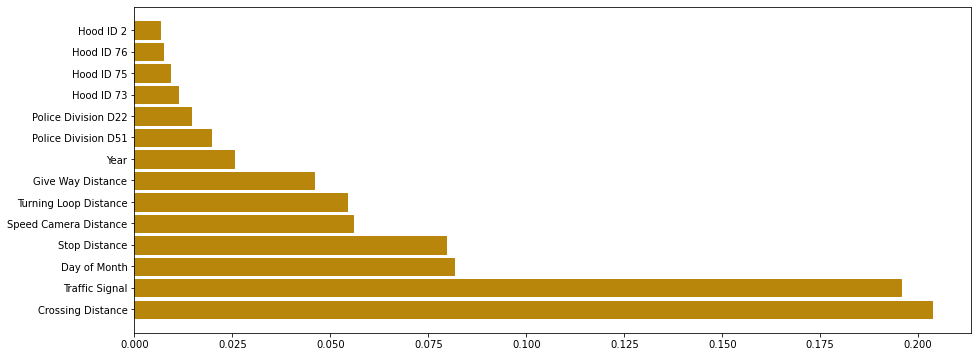

In [35]:
import matplotlib.pyplot as plt

figure, ax = plt.subplots(1, figsize=(15, 6))
ax.barh(robbery_vif['Variable'][1:16],robbery_vif['VIF'][1:16].astype(float), color = "darkgoldenrod", ec="darkgoldenrod")

save_results_to = 'C:/Users/jodyn/PycharmProjects/InsightFDS/notebooks/figures/'
plt.savefig(save_results_to + 'Feature-Importance_Mug.png', dpi = 300)

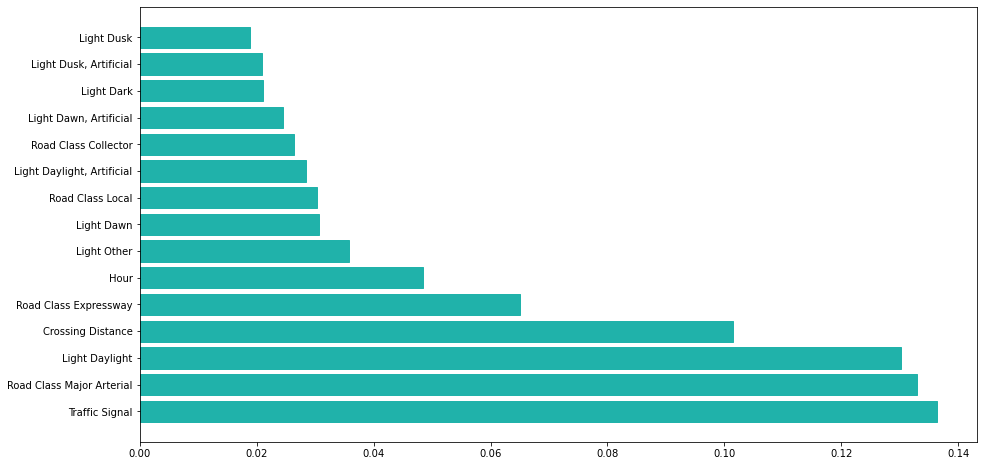

In [38]:
figure, ax = plt.subplots(1, figsize=(15, 8))
ax.barh(pedestrian_vif['Variable'][6:21],pedestrian_vif['VIF'][6:21].astype(float), color = "lightseagreen", ec="lightseagreen")
save_results_to = 'C:/Users/jodyn/PycharmProjects/InsightFDS/notebooks/figures/'
plt.savefig(save_results_to + 'Feature-Importance_Car.png', dpi = 300)

# Predicting Risks - Random Forest

In [39]:
# I am going to run this on the full dataset
# and select the features in this final model
pedestrian_features_final = pandas.DataFrame(pedestrian_features,
                                          columns=pedestrian_features_names)
robbery_features_final = pandas.DataFrame(robbery_features,
                                          columns=robbery_model_names)

In [40]:
# will add these data to the main dataframe
pedestrian_model_data_dummies_bal['Collison'] = pandas.DataFrame((pedestrian_model_best_RF.predict_proba(pedestrian_features_final)))[1]

robbery_model_data_dummies_bal['Mugging'] = pandas.DataFrame((robbery_model_best_RF.predict_proba(robbery_features_final)))[1]


In [41]:
pedestrian_model_data_dummies_bal[['Longitude','Latitude','Collison']]

Longitude      Latitude  Collison
0      612730.2037  4.838000e+06  0.494655
1      629087.5448  4.844941e+06  0.388446
2      638804.6704  4.843354e+06  0.413212
3      617688.5935  4.834947e+06  0.194435
4      630134.5419  4.837459e+06  0.135397
...            ...           ...       ...
12861  639204.2688  4.847322e+06  0.920694
12862  639204.2688  4.847322e+06  0.920694
12863  630795.4543  4.834567e+06  0.915382
12864  630795.4543  4.834567e+06  0.915382
12865  620372.1903  4.828528e+06  0.877583

[12866 rows x 3 columns]

In [42]:
robbery_model_nodes = robbery_model_data_dummies_bal[['Longitude','Latitude','Mugging']]
pedestrian_model_nodes = pedestrian_model_data_dummies_bal[['Longitude','Latitude','Collison']]

In [43]:
def create_gdf(df, Longitude, Latitude, projection):
    return geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df[Longitude], df[Latitude]),
                                  crs=projection)

# need as a geopanda dataframe to append to nodes
pedestrian_model_nodes_2958 = create_gdf(pedestrian_model_nodes,                                      
                                      Longitude='Longitude',
                                      Latitude='Latitude',
                                      projection="EPSG:2958")

In [44]:
robbery_model_nodes_2958 = create_gdf(robbery_model_nodes,
                                      Longitude='Longitude',
                                      Latitude='Latitude',
                                      projection="EPSG:2958")

In [45]:
robbery_model_nodes_2958.to_pickle("C:/Users/jodyn/Google Drive/Insight Data Science/Insight/Processed Data/robbery_model_nodes_2958.pkl")
pedestrian_model_nodes_2958.to_pickle("C:/Users/jodyn/Google Drive/Insight Data Science/Insight/Processed Data/pedestrian_model_nodes_2958.pkl")

Juptyter crashed when I tried to do the edge weights in here. So, I wil finish in PyCharm.